<a href="https://colab.research.google.com/github/Nisarg03/Astrophysics/blob/main/PyCBC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Searches for Gravitational Waves with PyCBC

We will be using the [PyCBC package](https://pycbc.org/) for the first half of the tutorials. The package contains classes and utilities providing tools and methods for:
* reading the detector data
* conditioning the detector data
* creating a detector response model
* waveform generation interface
  * interface to existing libraries (LALSimulation, TaylorF2e, SEOBNRe, etc..)
* Template bank placement
* Matched-filtering
* Signal-Consistency test
* Candidate Ranking statistcs

There is quite a [well-curated documentation](https://pycbc.org/pycbc/latest/html/) which I will recommend everyone interested to visit. You can also take a look at the published articles listed [here](https://pycbc.org/pycbc/latest/html/credit.html).

SlimTheseAfricanbushviper-size_restricted.gif" width="310" height="216" />

### **0**:  Set-up
Install required packages (this may take a few minutes)
For the moment, let us use google colab for the purpose.

In [ ]:
import sys
!{sys.executable} -m pip install lalsuite pycbc seaborn ligo-common --no-cache-dir

     |████████████████████████████████| 27.3MB 1.3MB/s 
     |████████████████████████████████| 16.8MB 30.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.6MB 50.5MB/s 
     |████████████████████████████████| 51kB 43.9MB/s 
     |████████████████████████████████| 890kB 46.9MB/s 
     |████████████████████████████████| 81kB 46.8MB/s 
     |████████████████████████████████| 61kB 42.9MB/s 
     |████████████████████████████████| 2.6MB 37.7MB/s 
  Created wheel for pycbc: filename=PyCBC-1.16.12-cp36-cp36m-linux_x86_64.whl size=5740573 sha256=1fd69daadb33e18dd2d8ca3a904e2b7c7bbd0628b249c9f35a78acb900636e0d
  Stored in directory: /tmp/pip-ephem-wheel-cache-u7r7jaxj/wheels/36/e5/bd/1093b0d0d90b6431d76f263066374b10c6470128b7b2cd035f
Successfully built pycbc
  Created wheel for lscsoft-glue: filename=lscsoft_glue-2.0.0-cp36-cp36m-linux_x86_64.whl size=414150 sha256=e1c6a

### 1.1 Catalogue of Observed Gravitational-wave Mergers
Information about the growing catalog of gravitational-wave mergers can be accessed through the `pycbc.catalog` package. Some key information such as the chirp mass ($\mathcal{M}_c = \frac{(m_1 m_2)^{3/5}}{(m_1 + m_2 )^{1/5}}$) can be retrieved. Let us begin by taking a look at the name of the mergers seen in the first and second observing run.


In [ ]:
from pycbc import catalog

### List the mergers in the catalog
for merger_name in catalog.Catalog(source = 'gwtc-1'):
    print(merger_name)

GW150914-v3
GW151012-v3
GW151226-v2
GW170104-v2
GW170608-v3
GW170729-v1
GW170809-v1
GW170814-v3
GW170817-v3
GW170818-v1
GW170823-v1


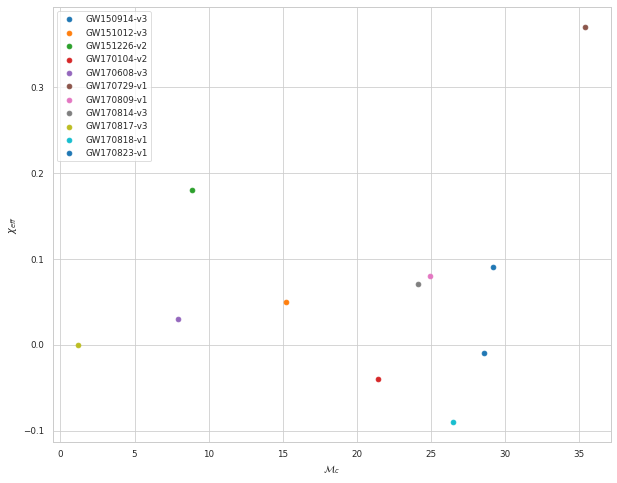

In [ ]:
%matplotlib inline
import pylab, seaborn as sns

sns.set_context("paper")
sns.set_style("whitegrid")

pylab.figure(figsize=(10,8))
for merger_name in catalog.Catalog(source='gwtc-1'):
  m = catalog.Merger(merger_name)
  mchirp, elow, ehigh = m.median1d('mchirp', return_errors=True)
  spin = m.median1d('chi_eff')
  distance = m.median1d('distance')
  pylab.scatter(mchirp, spin, label=merger_name)

pylab.xlabel('$\mathcal{M}_c$')
pylab.ylabel('$\chi_{eff}$')
pylab.legend()
pylab.show()

### Transform Mass Parameters into the Detector Frame
By default the above interface returns parameters in the source frame. This is what is interesting to astrophysicists in general. However, due to cosmological redshift, gravitational-waves are stretched as they travel. This causes the observed waveform to be different in the detector frame. This corresponds to an observed change in the mass parameters. However, the relationship is fairly straighforward. For example, $\mathcal{M}_c^{det} = (1+z) \mathcal{M}_c$. 

In [ ]:
m = catalog.Merger('GW170729')
source_mchirp = m.median1d('mchirp')
redshift = m.median1d('redshift')
det_mchirp = source_mchirp * (1 + redshift)

print('Chirp Mass of GW170729')
print('Source Frame: {} Solar Masses'.format(source_mchirp))
print('Detector Frame: {} Solar Masses'.format(det_mchirp))

Chirp Mass of GW170729
Source Frame: 35.4 Solar Masses
Detector Frame: 52.745999999999995 Solar Masses


## 1.2 Accessing LIGO/Virgo data
All data generated and recorded by the current generation of ground-based laser-interferometer gravitational-wave detectors are stored mostly in gravitational-wave frame (`gwf`) files (For public usage, they are also released in `hdf5` format and `txt` format). These files typically contain data from several sources bundled into a single, time-stamped set, along with the metadata for each channel.


In this section, we will look into how to read these detector data.

### 1.2.1 Getting Data Around Specific Binary Merger in the Catalogue

One can directly retrieve data around a specific event using the following procedure. Typically this data is centred on the event, though restrictions may apply which have not allowed this. This method, by default, gets the smallest version of the dataset.

Duration: 32.0s Start: 1185389792 End: 1185389824


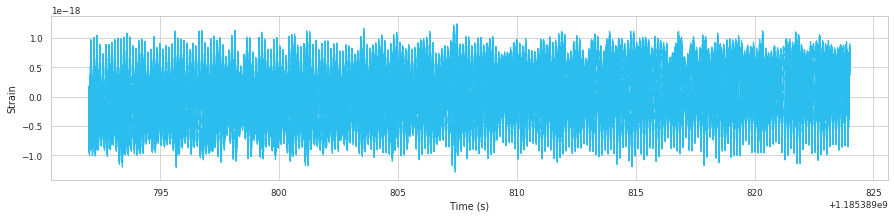

In [ ]:
m = catalog.Merger("GW170729")

# Get the time series data around GW150914 from Hanford
# 'ts_han' is a pycbc.types.TimeSeries object which contains
# gravitational-wave strain in this instance and has metadata
# such as the start time, and sample rate.
ts_han = m.strain('H1')

# And now livingston
ts_liv = m.strain('L1')

# We can see how much data was returned and its boundaries
# Note: All times are given in seconds since the GPS time epoch
pylab.figure(figsize=(15,3))
print("Duration: {}s Start: {} End: {}".format(ts_han.duration, 
                                              int(ts_han.start_time),
                                              int(ts_han.end_time)))

# We can directly plot the time series as follows
pylab.plot(ts_han.sample_times, ts_han, color="#2CBDEF")
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.show()

The above strategy won't work if you are trying to look into parts of the data where there are no astrophysical signals. Hence in almost all cases, for search purpose, the following two methods are used. 

### 1.2.2 Querying an LDR server
The LIGO Data Replicator (LDR) is a tool for replicating data sets to different data grids. If you have access to an LDR server, you can read GWF files using `pycbc.frame` module as follows:

In [ ]:
from pycbc.frame import query_and_read_frame

# Retrieve the approximate time of the merger
centre_time = 1126259462
start = centre_time - 32
end = centre_time + 32

# Get 64 seconds of data roughly around the centre time
# The start / end time may be any in the publicly available data sets.
ts = query_and_read_frame('LOSC', 'H1:LOSC-STRAIN', start, end)

# If we wanted to retreive data from the Livingston detector
# we'd use the following command instead
# ts = query_and_read_frame('LOSC', 'L1:LOSC-STRAIN', start, end)

print("Returned {}s of data at {}Hz".format(ts.duration, ts.sample_rate))

Returned 64.0s of data at 4096.0Hz


### 1.2.3 Directly reading from downloaded frame files
The `pycbc.frame` module also provides methods for reading frame files stored in your computer. To demonstrate that let us download 32s long data sampled at 4kHz from two detector data.

In [ ]:
!wget https://www.gw-openscience.org/eventapi/html/GWTC-2/GW190521/v3/L-L1_GWOSC_4KHZ_R1-1242442952-32.gwf
!wget https://www.gw-openscience.org/eventapi/html/GWTC-2/GW190521/v3/H-H1_GWOSC_4KHZ_R1-1242442952-32.gwf
#!wget https://www.gw-openscience.org/eventapi/html/GWTC-2/GW190521/v3/V-V1_GWOSC_4KHZ_R1-1242442952-32.gwf

--2020-12-08 03:56:00--  https://www.gw-openscience.org/eventapi/html/GWTC-2/GW190521/v3/L-L1_GWOSC_4KHZ_R1-1242442952-32.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /eventapi/html/GWTC-2/GW190521/v3/L-L1_GWOSC_4KHZ_R1-1242442952-32.gwf/ [following]
--2020-12-08 03:56:00--  https://www.gw-openscience.org/eventapi/html/GWTC-2/GW190521/v3/L-L1_GWOSC_4KHZ_R1-1242442952-32.gwf/
Reusing existing connection to www.gw-openscience.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1027642 (1004K) [application/x-gwf]
Saving to: ‘L-L1_GWOSC_4KHZ_R1-1242442952-32.gwf’

L-L1_GWOSC_4KHZ_R1- 100%[===================>]   1004K  2.60MB/s    in 0.4s    

2020-12-08 03:56:01 (2.60 MB/s) - ‘L-L1_GWOSC_4KHZ_R1-1242442952-32.gwf’ saved [1027642/1027642]

--2020-12-08 03:56:01--  https://www.gw

We can read the frame files then as follows:

In [ ]:
from pycbc.frame import read_frame

# Read the data directly from the Gravitational-Wave Frame (GWF) file.
ifo = ['L1','H1']
files = ["L-L1_GWOSC_4KHZ_R1-1242442952-32.gwf", "H-H1_GWOSC_4KHZ_R1-1242442952-32.gwf"]
# The Frame Files are 
channel_name = ["L1:GWOSC-4KHZ_R1_STRAIN", "H1:GWOSC-4KHZ_R1_STRAIN"]
start = 1242442967.4 - 15
end = start + 30
data = {}
for i in range(len(files)):
  data[ifo[i]] = read_frame(files[i], channel_name[i], start, end)

### 1.4 Visualising the Data

For sanity check, let us make a plot of our data.

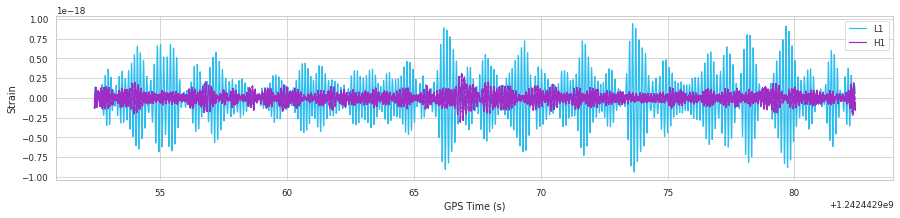

In [ ]:
colors = ["#2CBDEF", '#9D2EC5', '#EC1C4B']
colors2 = ["#EC1C4B", '#355C7D']
i = 0
pylab.figure(figsize=(15,3))
for ifo in data:  
    pylab.plot(data[ifo].sample_times, data[ifo], label=ifo, color=colors[i])
    i = i + 1
pylab.ylabel('Strain')
pylab.xlabel('GPS Time (s)')
pylab.legend()
pylab.show()

Notes: There are alternatives ways to access the GWOSC data. For example:
* `readligo` is a light-weight Python module that returns the time series into a Numpy array.
* `gwpy` is also a light-weight Python package which too can read the strain data and store it as `timeseries` object. 


## 2. Visual Processing of GW190521

A typical gravitational wave strain data will have contributions from detector noise $n(t)$ and an occassional measurable gravitational wave signal $h(t)$. If we consider the detector data is linear, we may write the strain $s(t)$ as:

$s(t) = n(t) + h(t)$

For our playground case, we already know that a signal $h(t)$ exist in the data with peak amplitude and frequency at GPS time of 1242442967.4 (21st May 2019, 8:30 am IST). Let us try to mine out this signal!


### 2.1 Zoom into 1 second nearby to GW190521
When you just zoom in to one second around GW190521, all you can see is the low frequency behavior of the noise, since it is much louder than the higher frequency noise (and signal).


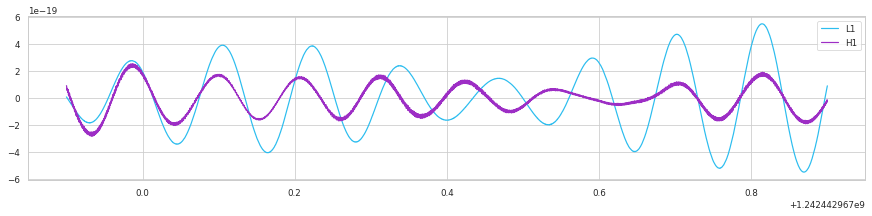

In [ ]:
end_time = 1242442967.4
i = 0 
pylab.figure(figsize=(15,3))
for ifo in data:
    # The time slice method can give just a portion of the time
    # series using GPS start and stop times
    zoom = data[ifo].time_slice(end_time - 0.5, end_time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo, color=colors[i])
    i = i + 1
pylab.legend()
pylab.show()

### 2.2 Highpass the data to remove the low-frequency content
Let us apply a highpass filter to the data to suppress the low-frequency noise of the instruments. We can see that this brings the dynamic range of the data mainly into the same range. However, there is still some dominant frequencies.

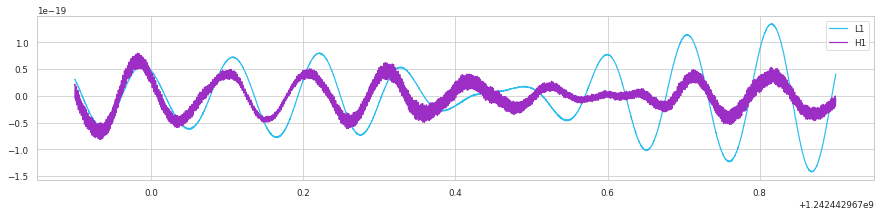

In [ ]:
end_time = 1242442967.4
i = 0 
pylab.figure(figsize=(15,3))
for ifo in data:
    # Apply a highpass filter to the data. This suppresses the low
    # frequency content of the data. We choose here a finite-impulse-response (FIR).
    # Options
    # 1) highpass frequency
    # 2) half sample length of highpass filter 
    #(higher value will give less ripple in passband)
    high_data = data[ifo].highpass_fir(11, 512) # Highpass point is 15 Hz
    
    # The time slice method can give just a portion of the time
    # series using GPS start and stop times
    zoom = high_data.time_slice(end_time  - 0.5, end_time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo,color=colors[i])
    i = i + 1
pylab.legend()
pylab.show()

### 2.3 Power Spectral Density of the data
Most data recorded from a gravitational-wave interferometer carry information across a wide band of frequencies, typically up to a few kiloHertz, but often it is the case that the low-frequency amplitude dwarfs that of the high-frequency content, making discerning high-frequency features difficult.

We employ a technique called ‘whitening’ to normalize the power at all frequencies so that excess power at any frequency is more obvious.

To do that, we first estimate the power spectral density (a.k.a. PSD) of our data.  In this section, we use a version of [Welch's method](https://en.wikipedia.org/wiki/Welch%27s_method) to estimate the power spectral density of the timeseries.

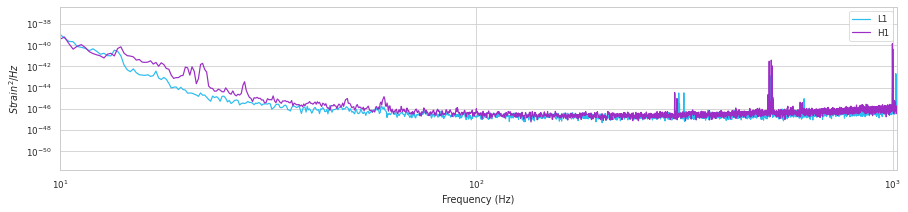

In [ ]:
pylab.figure(figsize=(15,3))
i = 0
for ifo in data:
    # This estimates the PSD by sub-dividing the data into overlapping
    # 4s long segments. (See Welch's method)
    psd = data[ifo].psd(4)
    # Note that the psd is a FrequencySeries!
    pylab.loglog(psd.sample_frequencies, psd, color=colors[i], label=ifo)
    i = i + 1
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.xlim(10, 1024)
pylab.legend()

Note that there is a significant amount of noise at low frequencies (orders of magnitude). Note also that there is a large amount of power at a few specific frequencies. The causes for these include 60 Hz power line noise, violin modes of the hanging mirrors, and various other instrumental resonances.

We can use the estimated PSD to normalise the power at all frequencies so that excess power at any frequency is more obvious. Here however, we will be using the `whiten` method of the `timeseries` object.

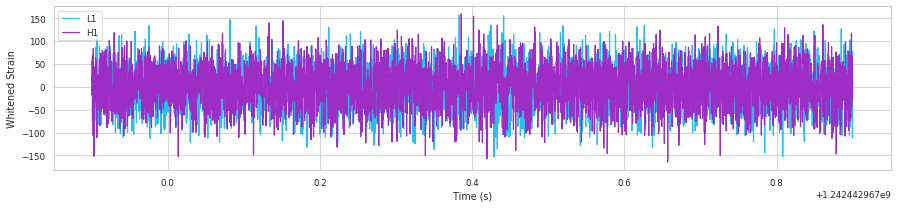

In [ ]:
# Whiten the data
whitened = {}
pylab.figure(figsize=(15,3))
i = 0
for ifo in data:
    # This produces a whitened set.
    # This works by estimating the power spectral density from the
    # data and then flattening the frequency response.
    # (1) The first option sets the duration in seconds of each
    #     sample of the data used as part of the PSD estimate.
    # (2) The second option sets the duration of the filter to apply
    whitened[ifo] = data[ifo].whiten(4, 4)

    zoom = whitened[ifo].time_slice(end_time - 0.5, end_time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo, color=colors[i])
    i = i + 1
pylab.ylabel('Whitened Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.show()

We will now bandpass the data around GW190521 between 11 - 250 Hz. This will remove frequency ranges which won’t contribute to this kind of signal and make it possible to see the signal in question.

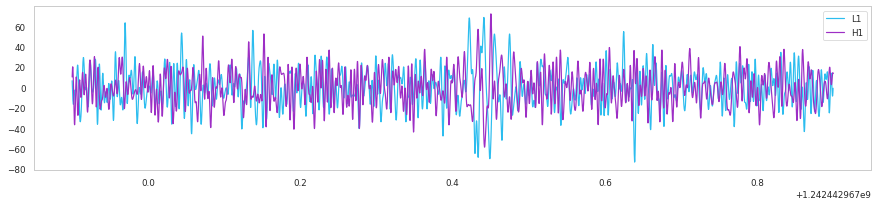

In [ ]:
pylab.figure(figsize=(15,3))
i = 0
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 250 Hz)
    bpsd = whitened[ifo].highpass_fir(11, 512).lowpass_fir(250, 512)
    
    zoom = bpsd.time_slice(end_time - 0.5, end_time + 0.5)
    pylab.plot(zoom.sample_times, zoom, label=ifo, color=colors[i])
    i = i + 1
pylab.grid()
pylab.legend()
pylab.show()

# Focus the Plot around GW190521
In the above plot we can see that there is some excess signal that sticks above the noise. Let’s zoom around the end time now, and align the two time series.

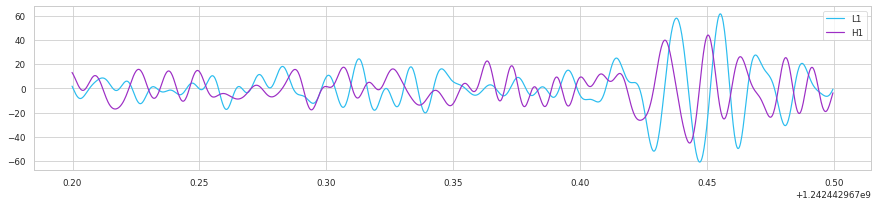

In [ ]:
i = 0
pylab.figure(figsize=[15, 3])
for ifo in whitened:
    # Apply a highpass filter (at 30 Hz) followed by an lowpass filter (at 120 Hz)
    bpsd = whitened[ifo].highpass_fir(11, 512).lowpass_fir(120, 512)
    
    # Now we'll specially align the L1 data. Where does this come from?
    # (1) We already knew that the signal was ~ 7 ms separated between detectors.
    # (2) The two LIGO interferometers are roughly aligned so that the output of
    #     one is a sign change of the other for *many* sky locations. This is an
    #     approximation and doesn't hold for all possible source sky locations.
    # A later tutorial will show how to estimate this alignment more precisely.
    if ifo == 'L1':
        bpsd.roll(int(bpsd.sample_rate * .007))
        bpsd *= -1
    
    # We'll choose a tighter zoom here.
    zoom = bpsd.time_slice(end_time - 0.2, end_time + .1)
    pylab.plot(zoom.sample_times, zoom, label=ifo, color=colors[i])
    i = i + 1
pylab.legend()
pylab.show()

Aha! Can you see those ripples?


### 2.4 Generate the Q-transform of a TimeSeries

One of the most useful tools for visualising short-duration features in a `TimeSeries` is the [Q-transform](https://en.wikipedia.org/wiki/Constant-Q_transform). This is regularly used by the Detector Characterization working groups of the LIGO Scientific Collaboration and the Virgo Collaboration to produce high-resolution time-frequency maps of transient noise (glitches) and potential gravitational-wave signals.



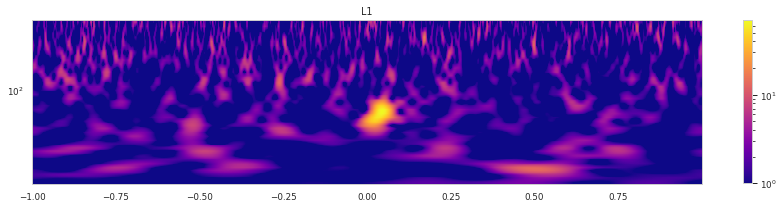

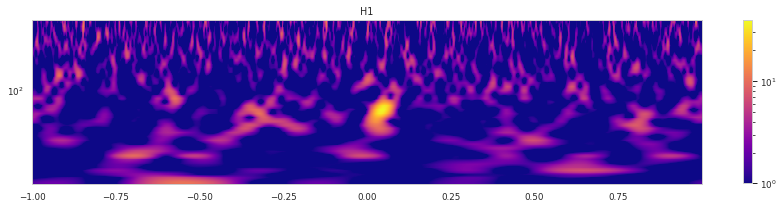

In [ ]:
from matplotlib.colors import LogNorm
end_time = 1242442967.4
for ifo in whitened:
    # We'll choose a tighter zoom here.
    zoom = whitened[ifo].time_slice(end_time - 1, end_time + 1)
                    
    # The qtransform method returns a vector of the sample times, frequencies, and a 2-d vector of the 
    # power in each time-frequency bin. The free parameter is the choice of the Q-value. Larger Q-values
    # are generally more appropriate for viewing long duration features of the data and vice versa. 
                    
    # The options here:
    # (1) The time spacing for the output image (i.e. 1 ms in this case)
    # (2) The number of frequency bins in the output, logarithmically spaced
    # (3) The qrange to maximize over. We'll pick a constant at 8 here
    #     Typically higher values will be more appropriate for longer duration
    #     signals
    # (4) The frequency range to output
    times, freqs, power = zoom.qtransform(.001, logfsteps=200,
                                                qrange=(4, 64),
                                                frange=(11, 512))
    pylab.figure(figsize=[15, 3])
    norm = LogNorm(vmin=1, vmax=power.max())
    pylab.pcolormesh(times - end_time, freqs, power,norm=norm, cmap='plasma')
    pylab.title(ifo)
    pylab.colorbar()
    pylab.yscale('log')
    pylab.show()


Even though it might be harder to spot visually, you can already see GW190521 in the Q-transform output. In practice, we use this only after we found the exact end-time of the astrophysical signal whose existence we don't know a priori. In a later section we will learn how we can find a signal in our data using the method of matched-filtering.

### 3. Generating your first waveform !

In this tutorial we are restricting ourselves to the template based searches for compact binary mergers of the kind performed by the LIGO and Virgo collaborations. So in this section we will learn how to generate waveforms from compact binary mergers.

Let us first see what waveforms we can generate.


In [ ]:
from pycbc.waveform import td_approximants, fd_approximants

# List of td approximants that are available
print(td_approximants())

# List of fd approximants that are currently available
print(fd_approximants())

# Note that these functions only print what is available for your current
# processing context.

['TaylorT1', 'TaylorT2', 'TaylorT3', 'SpinTaylorT1', 'SpinTaylorT4', 'SpinTaylorT5', 'PhenSpinTaylor', 'PhenSpinTaylorRD', 'EOBNRv2', 'EOBNRv2HM', 'TEOBResum_ROM', 'SEOBNRv1', 'SEOBNRv2', 'SEOBNRv2_opt', 'SEOBNRv3', 'SEOBNRv3_pert', 'SEOBNRv3_opt', 'SEOBNRv3_opt_rk4', 'SEOBNRv4', 'SEOBNRv4_opt', 'SEOBNRv4P', 'SEOBNRv4PHM', 'SEOBNRv2T', 'SEOBNRv4T', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'HGimri', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'TaylorEt', 'TaylorT4', 'EccentricTD', 'SpinDominatedWf', 'NR_hdf5', 'NRSur7dq2', 'NRSur7dq4', 'SEOBNRv4HM', 'NRHybSur3dq8', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'IMRPhenomXP', 'IMRPhenomXPHM', 'TEOBResumS', 'TaylorF2', 'SEOBNRv1_ROM_EffectiveSpin', 'SEOBNRv1_ROM_DoubleSpin', 'SEOBNRv2_ROM_EffectiveSpin', 'SEOBNRv2_ROM_DoubleSpin', 'EOBNRv2_ROM', 'EOBNRv2HM_ROM', 'SEOBNRv2

So we can either generate time domain or frequency domain waveform. Such a waveform is typically described in terms of three phases: “inspiral” when the two bodies orbit each other, “merger” when the two bodies collide, “ringdown” (sometimes referred to as “post-merger” for binary neutron star inspirals) where the remnant returns to a stationary state, i.e., a rotating, Kerr, black hole. These waveforms depend on a number of parameters such as the masses of the components, the spins of the components, the orientation of the source with respect to the observer etc.. For an excellent introduction take a look at [this paper](https://arxiv.org/abs/1608.01940).

### 3.1 Plotting Time Domain Waveforms

In this tutorial we will predominantly use the aligned spin non-precessing waveform, `IMRPhenomD` which was first introduced in [this paper](https://doi.org/10.1103/PhysRevLett.113.151101). To begin with let us assume a randomly oriented symmetric source with $M_T = 200 M_\odot$ and the component spins are aligned to the binary black hole. ([Check out this page for a visual understanding of how spin affects the signal](http://www.gw-indigo.org/tiki-index.php?page=Inspiralling+black-hole+binaries))

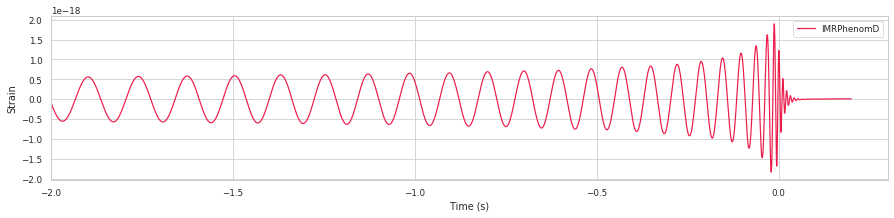

In [ ]:
import pylab, numpy
from pycbc.waveform import get_td_waveform
pylab.figure(figsize=(15,3))
apx = 'IMRPhenomD'
inclination = numpy.random.uniform(0, 3.14, 1)
hp, hc = get_td_waveform(approximant=apx,
                                 mass1 = 100,
                                 mass2 = 100,
                                 spin1z = 0.3,
                                 spin2z = 0.2,
                                 inclination = inclination,
                                 delta_t=1.0/4096,
                                 f_lower=5)

pylab.plot(hp.sample_times, hp, label=apx, color=colors[i])
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.xlim(-2,0.3)
pylab.show()

### 3.2 Generating same waveform in multiple detectors. 

Depending on the detector locations and its relative orientation with the source, the response of a detector to an incoming astrophysical signal changes. To demonstarte this affect let us plot a simulated gravitational wave signal as seen by the two LIGO observatory.

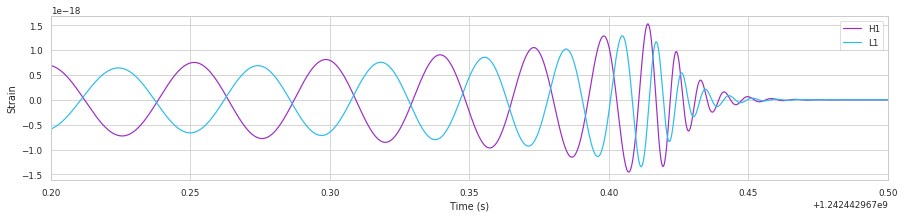

In [ ]:
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector
apx = 'IMRPhenomD'
# NOTE: Inclination runs from 0 to pi, with poles at 0 and pi
#       coa_phase runs from 0 to 2 pi.
hp, hc = get_td_waveform(approximant=apx,
                         mass1=90,
                         mass2=65,
                         spin1z = 0.024,
                         spin2z = 0.39,
                         inclination=0.44,
                         coa_phase=2.06,
                         delta_t=1.0/4096,
                         f_lower=11)

det_h1 = Detector('H1')
det_l1 = Detector('L1')
det_v1 = Detector('V1')

# Choose a GPS end time, sky location, and polarization phase for the merger
# NOTE: Right ascension and polarization phase runs from 0 to 2pi
#       Declination runs from pi/2. to -pi/2 with the poles at pi/2. and -pi/2.
end_time = 1242442967.4
declination = -1.14
right_ascension = 6.26 
polarization = 2.30
hp.start_time += end_time
hc.start_time += end_time

signal_h1 = det_h1.project_wave(hp, hc,  right_ascension, declination, polarization)
signal_l1 = det_l1.project_wave(hp, hc,  right_ascension, declination, polarization)
pylab.figure(figsize=(15,3))
pylab.plot(signal_h1.sample_times, signal_h1, label='H1', color=colors[1])
pylab.plot(signal_l1.sample_times, signal_l1, label='L1', color=colors[0])

pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.xlim(end_time -0.2, end_time + 0.1)
pylab.legend()
pylab.show()

If you look carefully you can see there is a delay in the Hanford waveform as compared to Livington one. This is because gravitational wave signal, like light travels with a finite speed (within error bounds it is same as speed of light. Take a look at [this article for details](https://arxiv.org/abs/1707.06101)). 

### 4. Signal Processing of GW190521

The raw ‘strain’ output of the gravitational wave detectors is recorded as a `TimeSeries` with contributions from a large number of known and unknown noise sources, as well as possible gravitational wave signals.

In order to uncover a real signal we need to "filter" out noises that otherwise hide the signal in the data. To do that we will first pre-condition our detector data and evaluate the PSD as before.

### 4.1 Preconditioning the data


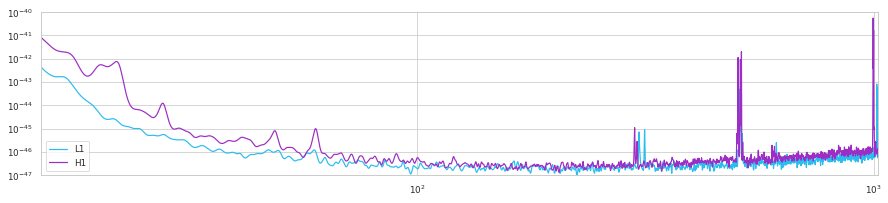

In [ ]:
from pycbc.frame import read_frame
from pycbc.filter import highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Read the data directly from the Gravitational-Wave Frame (GWF) file.
ifo = ['L1','H1']
files = ["L-L1_GWOSC_4KHZ_R1-1242442952-32.gwf", "H-H1_GWOSC_4KHZ_R1-1242442952-32.gwf"]
# The Frame Files are 
channel_name = ["L1:GWOSC-4KHZ_R1_STRAIN", "H1:GWOSC-4KHZ_R1_STRAIN"]
start = 1242442967.4 - 15
end = start + 30
strain, stilde = {}, {}
psds = {}
pylab.figure(figsize=(15,3))
for i in range(len(files)):
  ts = read_frame(files[i], channel_name[i], start, end)
  # Remove the low frequency content of the detector data
  strain[ifo[i]] = highpass(ts, 11)

  # Remove the time corrupted by the high-pass filter
  strain[ifo[i]] = strain[ifo[i]].crop(4, 4)

  # Also create a frequency domain version of the data
  stilde[ifo[i]] = strain[ifo[i]].to_frequencyseries()
  # Calculate a psd from the data. We'll use 2s segments in a median - welch style estimate
  # We then interpolate the PSD to the desired frequency step. 
  psds[ifo[i]] = interpolate(strain[ifo[i]].psd(2), stilde[ifo[i]].delta_f)
  # We explicitly control how much data will be corrupted by overwhitening the data later on
  # In this case we choose 2 seconds.
  psds[ifo[i]] = inverse_spectrum_truncation(psds[ifo[i]], int(2 * strain[ifo[i]].sample_rate),
                                  low_frequency_cutoff=12.0,
                                  trunc_method='hann')
  pylab.loglog(psds[ifo[i]].sample_frequencies, psds[ifo[i]], label=ifo[i], color=colors[i])
  pylab.xlim(15, 1024)
  pylab.ylim(1e-47, 1e-40)
pylab.legend()

### 4.2 Calculating the SNR associated with a given astrophysical signal model
At this point we are ready to calculate the matched-filter SNR. To do so,we need a signal model against which to compare our data. We assume a non-spinning waveform parameterised by black hole of equal component masses. 

Text(0, 0.5, 'Strain')

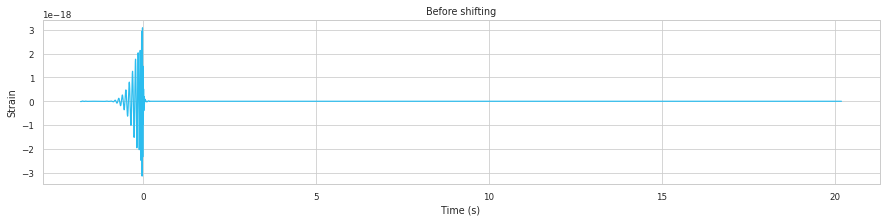

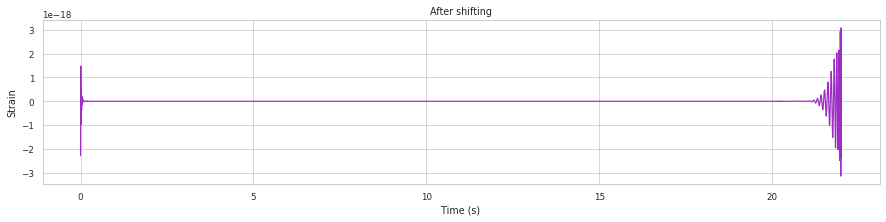

In [ ]:
from pycbc.waveform import get_td_waveform
# In this case we "know" what the signal parameters are. In a search
# we would grid over the parameters and calculate the SNR time series
# for each one

# We'll assume equal masses, and non-rotating black holes which is within the posterior probability
# of GW190521. 
m = 135 # Solar masses
hp, hc = get_td_waveform(approximant="IMRPhenomD",
                     mass1=m,
                     mass2=m,
                     delta_t=strain['H1'].delta_t,
                     f_lower=11)

# We will resize the vector to match our data
hp.resize(len(strain['H1']))

# The waveform begins at the start of the vector, so if we want the
# SNR time series to correspond to the approximate merger location
# we need to shift the data so that the merger is approximately at the 
# first bin of the data.

# The cyclic_time_shift method shifts the timeseries by a given amount of time.
# It treats the data as if it were on a ring so points shifted off the end
# of the series reappear at the start. Note that time stamps are *not* in
# general affected (as the start time of the full array is shifted),
# but the index of each point in the vector is.
#
# By convention waveforms returned from `get_td_waveform` have their
# merger stamped with time zero, so we can use the start time to 
# shift the merger into position
pylab.figure(figsize=(15,3))
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp, color=colors[0])
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure(figsize=(15,3))
pylab.title('After shifting')
pylab.plot(template.sample_times, template,color=colors[1])
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

Once we have the model, we can matched filter the whitened strain data Conceptually, matched filtering involves laying the potential signal over your data and integrating (after weighting frequencies correctly). If there is a signal in the data that aligns with your ‘template’, you will get a large value when integrated over.

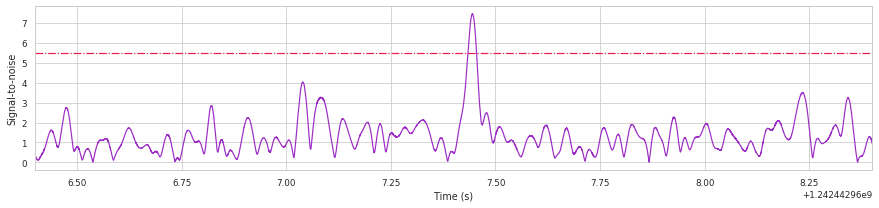

We found a signal at 1242442967.4446778s with SNR 7.469285542349678


In [ ]:
from pycbc.filter import matched_filter
import numpy
snr = matched_filter(template, strain['H1'],
                     psd=psds['H1'], low_frequency_cutoff=15)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seonds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why are we taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[15, 3])
pylab.plot(snr.sample_times, abs(snr),color=colors[1])
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.axhline(y=5.5, color=colors[2], linestyle='-.')
pylab.xlim(end_time - 1, end_time + 1)
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))


We see in the SNR time series plots above, that there is one nice peak around GW190521 in Hanford detector. However notice that there are also some large peaks at other times. This is because most gravitational wave strain data is plagued with transient noisy artefacts called as glitches which one must deal with to search for gravitational wave data with significant sensitivity. One approach for dealing with this is outlined later in this tutorial. 

However, in reality, we don't know the parameters describing the signal and hence we make a bunch of assumptions. The assumptions are typically motivated based on theoretical studies.

In most cases, we assume that the signal is coming from a quasi-circular binary and for computational reasons, we also presume that the binary is non-precessing in nature. Additionally we also believe that the significant part of the signal SNR comes from the dominant quadrupolar modes.

Here, we will make similar assumptions about the signal model and choose the following parameters:
* $m_1 \in [130 M_\odot, 170 M_\odot] $
* $m_2 \in [90 M_\odot, 130 M_\odot]$
* $s_{1z} \in [-0.5,0.7]$
* $s_{2z} \in [-0.7,0.6]$

Note that because of our assumptions, we are only able to recover a fraction of the signal's optimal SNR.

In [ ]:
import numpy
m1 = numpy.random.uniform(130, 170 , 40)
m2 = numpy.random.uniform(90, 130, 40)
s1z = numpy.random.uniform(-0.5, 0.7, 40)
s2z = numpy.random.uniform(-0.7, 0.6, 40)

In [ ]:
from pycbc.waveform import get_fd_waveform
from pycbc.filter import matched_filter

# # Variables to store when we've found the max
hmax, smax, tmax, nsnr = None, {}, {}, 0
m1max, m2max, s1zmax, s2zmax = 0, 0, 0, 0
snrs = []
ifo = 'H1'
for i in range(len(m1)):
    #Generate a waveform with a given component mass; assumed equal mass, nonspinning
    hp, hc = get_fd_waveform(approximant="IMRPhenomD", 
                             mass1=m1[i], 
                             mass2=m2[i],
                             spin1z = s1z[i],
                             spin2z = s2z[i],
                             f_lower=11, 
                             delta_f=stilde[ifo].delta_f)
    hp.resize(len(stilde[ifo]))
    
    # Matched filter the data and find the peak  
    max_snr, max_time = {}, {}
    for ifo in ['L1', 'H1']:
        snr = matched_filter(hp, stilde[ifo], psd=psds[ifo], low_frequency_cutoff=15.0)

        # The complex SNR at the peak
        snr = snr.time_slice(end_time - 1, end_time + 1)
        _, idx = snr.abs_max_loc()
        max_snr[ifo] = snr[idx]
        
        # The time of the peak
        max_time[ifo] = float(idx) / snr.sample_rate + snr.start_time
    
    network_snr = (abs(numpy.array(list(max_snr.values()))) ** 2.0).sum() ** 0.5
    snrs.append(max_snr)
    
    # Keep track of only the loudest peak
    if network_snr > nsnr:
        tmax, hmax, smax = max_time, hp, max_snr
        m1max, m2max, s1zmax, s2zmax = m1[i], m2[i], s1z[i], s2z[i]
        nsnr = network_snr

# See the SNR as a function of the component mass. Notice where this peaks as it gives us
# an estimate of what the parameters of the source system are. Note that masses
# here are in the *detector* frame, so if the source is located far away, it will in
# fact correspond to a lighter system due to cosmological redshift.
print("We found the signal with the highest network SNR is {:0.2f}".format(numpy.max(nsnr)))
print("at {}s in the Hanford detector".format(tmax['H1']))
print("and {}s in the Livingston detector".format(tmax['L1']))
print("And the parameters of best-matched template is:")
print("Mass 1={:0.2f}".format(m1max))
print("Mass 2={:0.2f}".format(m2max))
print("Spin 1z={:0.2f}".format(s1zmax))
print("Spin 2z={:0.2f}".format(s2zmax))
print("in the detector frame.")


We found the signal with the highest network SNR is 13.58
at 1242442967.462255954s in the Hanford detector
and 1242442967.458593845s in the Livingston detector
And the parameters of best-matched template is:
Mass 1=163.91
Mass 2=111.30
Spin 1z=0.50
Spin 2z=-0.37
in the detector frame.


### 4.3 Signal Consistency Test

However, the LIGO-Virgo noise is non-Gaussian and is plagued with instrumental artefacts, known as glitches which can often cause false-alarm. Hence, in order to identify gravitational-wave signals, we need additional methods to separate signals from noise. Below we will use the $\chi^2$-based signal consistency test that utilises our knowledge of CBC signals to help reject noisy artefacts. In this test we chop up our template into $p$ number of bins and see how much each contributes to the signal SNR ($\rho_i$). We can then calculate our statistic as the difference between the SNR in one bin, and the expected fraction of the total SNR ($\rho$).

$
\chi^2 = \sum^p_{i=0} (\rho_i - \rho / p)^2
$

This will have $2p-2$ degrees of freedom as each SNR is complex representing both possible orthogonal phases the signal could have contributions from. There is also a constraint due to the fact that the sum of each bin must each the total SNR by definition. In this notebook we will normalize this statistic by dividing by the number of degrees of freedom, producing $\chi^2_r$.

We expect that this statistic will be high when the template does not match well the data, and near unity when the data either is Gaussian noise, or it contains the expected signal in addition to Gaussian noise.



In [ ]:
from pycbc.vetoes import power_chisq

ifos = ['L1', 'H1']
chisq, snrs = {}, {}
for ifo in ifos:
  hp, hc = get_fd_waveform(approximant="IMRPhenomD", 
                             mass1=m1max, 
                             mass2=m2max,
                             spin1z = s1zmax,
                             spin2z = s2zmax,
                             f_lower=11, 
                             delta_f=stilde[ifo].delta_f)
  hp.resize(len(stilde[ifo]))
  # The number of bins to use. In principle, this choice is arbitrary. In practice,
  # this is empirically tuned.
  nbins = 10
  snrs[ifo] = matched_filter(hp, stilde[ifo], psd=psds[ifo], low_frequency_cutoff=15.0)
  snrs[ifo] = snrs[ifo].crop(5, 4)

  chisq[ifo] = power_chisq(hp, stilde[ifo], nbins, psd=psds[ifo], low_frequency_cutoff=15.0)
  chisq[ifo] = chisq[ifo].crop(5, 4)
  dof = nbins * 2 - 2
  chisq[ifo] /= dof

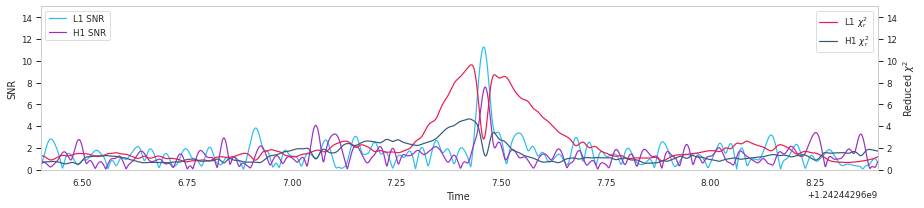

In [ ]:
fig, ax1 = pylab.subplots(figsize=(15,3))
ax2 = ax1.twinx()
i = 0 
for ifo in ifos:
  ax1.plot(snrs[ifo].sample_times, abs(snrs[ifo]), color = colors[i], label = ifo + ' SNR')
  ax2.plot(chisq[ifo].sample_times, chisq[ifo], color=colors2[i], label = ifo + ' $\\chi^2_{\\rm r}$')
  pylab.plot()
  i = i + 1 
ax1.set_ylabel('SNR')    
ax1.set_xlabel('Time')
pylab.xlim(end_time - 1, end_time + 1)
ax1.set_ylim(0,15)
ax2.set_ylim(0, 15)
ax2.grid()
ax1.grid()
ax2.set_ylabel('Reduced $\\chi^2$')
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

There are some notable features in the $\chi^2_r$ time series. We see that there is a dip in the value at the time of the peak in the SNR in each observatory. We expect this as the template now aligns with the signal in the data. Also, the values climb just around this minima. This occurs because the template is starting to slide against the true signal in the data but is not perfectly aligned with it.

### 4.4 Re-weighting our SNR to help down-weight times that don't fit our signal
One approach we can take is to down-weight the times where the data does not appear as either Guassian noise or Gaussian noise + our template. We can do this be combining the SNR time series and our $\chi^2_r$ time series as follows. This is a method used to re-weight SNR since initial LIGO, and has been employed in the first two Advanced LIGO observing runs. In this tutorial we will choose to rank our events by this statistic.

$\hat{\rho} = \frac{\rho}{ [1 + (\chi^2_r)^3]^{1/6}}$ where $\chi^2 \gt; 1$, otherwise $\rho$

For reference on how we rank coincident (i.e. occuring in multiple detector) events in Advanced LIGO, there is a description [here](http://iopscience.iop.org/article/10.3847/1538-4357/aa8f50/pdf).

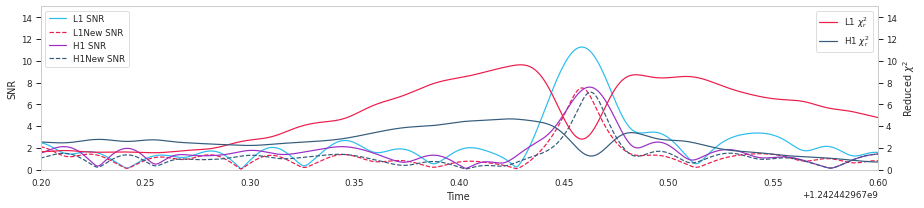

In [ ]:
from pycbc.events.ranking import newsnr

# The rho-hat term above is named "newsnr" here
nsnr = {ifo:newsnr(abs(snrs[ifo]), chisq[ifo]) for ifo in ifos}
# Show a couple sizes
fig, ax1 = pylab.subplots(figsize=(15,3))
ax2 = ax1.twinx()
linestyle = ["-", "--" ]
i = 0 
for ifo in ifos:
  ax1.plot(snrs[ifo].sample_times, abs(snrs[ifo]), color = colors[i], label = ifo + ' SNR')
  ax2.plot(chisq[ifo].sample_times, chisq[ifo], color=colors2[i], label = ifo + ' $\\chi^2_{\\rm r}$')
  ax1.plot(snrs[ifo].sample_times, nsnr[ifo], color = colors2[i], label = ifo + 'New SNR', linestyle=linestyle[1])
  pylab.plot()
  i = i + 1 
ax1.set_ylabel('SNR')    
ax1.set_xlabel('Time')
pylab.xlim(end_time - 0.2, end_time + 0.2)
ax1.set_ylim(0,15)
ax2.set_ylim(0, 15)
ax2.grid()
ax1.grid()
ax2.set_ylabel('Reduced $\\chi^2$')
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

Note the dotted lines. We can see above that there are still peaks around GW190521 in both the detectors, at roughly the same signal strength, but that at other times, where that had been peaks in the time series, there are no longer large statistic value.

### 4.5 Calculating the background and significance
In this section we will determine how significant the peak in the Hanford re-weighted SNR time series is.

We will do this first by determining where one might expect a peak relative to the LIGO Livigston observed peaks. This is set by the constraint that an astrophysical source can only cause delays between observatories no larger than the light travel time between them. The `pycbc.detector.Detector` class provides some convenient methods to ask these sorts of questions.

We will then calculate the peak in the SNR for this window around the LIGO observed peaks. This is our "on-source".

Finally, to determine the significance of the on-source we will compare how likely it is for a peak as large or larger to appear in the background. Our background will be empirically measured by taking portions of the SNR time series from the "off-source" i.e. times that do not overlap the on-source. An important criteria to avoid a biased significance estimate is that the background and experiment be performed in the same manner.



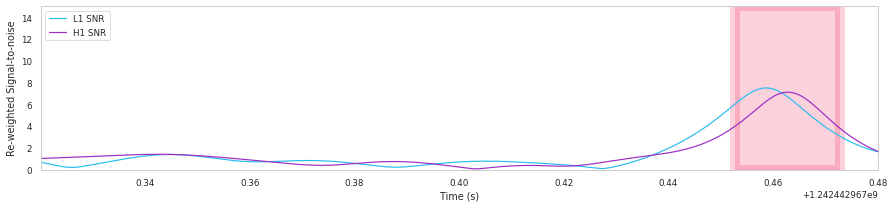

Hanford Peak has a statistic value of 7.111923393345454


In [ ]:
import numpy
from pycbc.detector import Detector

# Calculate the time of flight between the two LIGO detectors
d = Detector("H1")
time_of_flight = d.light_travel_time_to_detector(Detector('L1'))

# Record the time of the peak in Hanford Detector

pylab.figure(figsize=(15,3))
ptime_H1 = snrs['H1'].sample_times[nsnr['H1'].argmax()]
i = 0 
for ifo in ifos:
  pylab.plot(snrs[ifo].sample_times, nsnr[ifo], color=colors[i],label = ifo + ' SNR',linestyle=linestyle[0])
  i = i + 1
pylab.axvspan(ptime_H1 - time_of_flight , 
              ptime_H1 + time_of_flight, 
              alpha = 0.2, lw = 10, color=colors[2])

start = ptime_H1 - time_of_flight
end = ptime_H1 + time_of_flight

# convert the times to indices along with how large the region is in number of samples
window_size = int((end - start) * snrs['H1'].sample_rate)
sidx = int((start - snrs['H1'].start_time) * snrs['H1'].sample_rate)
eidx = sidx + window_size

# Calculate the "on-source" peak re-weighted (newsnr) statistic value.
onsource = nsnr['H1'][sidx:eidx].max()

pylab.legend()
pylab.grid()
pylab.xlim(end_time - .08, end_time + .08)
pylab.ylim(0, 15)
pylab.xlabel('Time (s)')
pylab.ylabel('Re-weighted Signal-to-noise')
pylab.show()

print('Hanford Peak has a statistic value of {}'.format(onsource))


In the plot above we see the re-weighted SNR time series. Only in the pink region, is it possible to have a peak in the SNR that is consistent with the LIGO-Livingston observatory.



In [ ]:
# Now that we've calculate the onsource peak, we should calculate the background peak values.
# We do this by chopping up the time series into chunks that are the same size as our
# onsource and repeating the same peak finding (max) procedure.

# Walk through the data in chunks and calculate the peak statistic value in each.
peaks = []
i = 0
while i + window_size < len(nsnr['H1']):
    p = nsnr['H1'][i:i+window_size].max()
    peaks.append(p)
    i += window_size
    
    # Skip past the onsource time
    if abs(i - sidx) < window_size:
        i += window_size * 2
    
peaks = numpy.array(peaks)

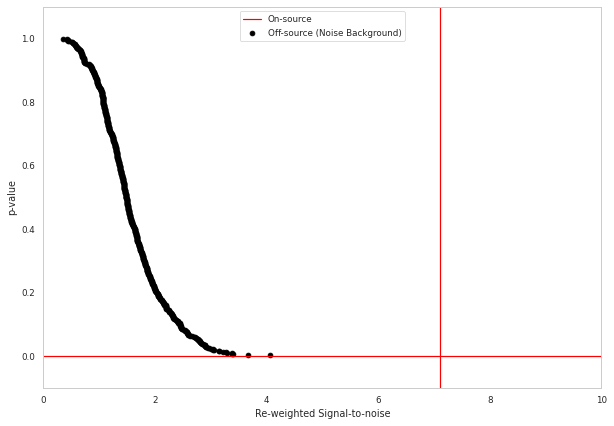

The p-value associated with the GW190521 peak is 0.0


In [ ]:
# The p-value is just the number of samples observed in the background with a 
# value equal or higher than the onsource divided by the number of samples.
# We can make the mapping between statistic value and p-value using our background
# samples.
pcurve = numpy.arange(1, len(peaks)+1)[::-1] / float(len(peaks))
peaks.sort()

pvalue = (peaks > onsource).sum() / float(len(peaks))

pylab.figure(figsize=[10, 7])
pylab.scatter(peaks, pcurve, label='Off-source (Noise Background)', color='black')

pylab.axvline(onsource, label='On-source', color='red')
pylab.axhline(pvalue, color='red')

pylab.legend()
#pylab.yscale('symlog')
pylab.grid()
pylab.ylim(-0.1, 1.1)
pylab.ylabel('p-value')
pylab.xlabel('Re-weighted Signal-to-noise')

pylab.xlim(0, 10)
pylab.show()

print("The p-value associated with the GW190521 peak is {}".format(pvalue))

So, we find a peak in Hanford as large as the obseved one and it has approximately 0% chance of occuring due to the noise alone. 
